In [1]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import requests
from collections import defaultdict

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "recipeNLG.csv"
df = pd.read_csv(dataset_path, index_col = 0)

# TESTING PURPOSES : Cull 99% of the data randomly to ensure faster data processing
# df = df.sample(n = int(len(df) * 0.01), random_state = 42).reset_index(drop = True)

df = df.drop(columns=['link', 'source', 'directions'], errors='ignore')

df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Show dataset sample
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231142 entries, 0 to 2231141
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   NER          object
dtypes: object(3)
memory usage: 68.1+ MB


In [3]:
# We need this list of measurement units for filtering (unfortunate really)
MEASUREMENT_UNITS = [
    'tsp', 'tbsp', 'c', 'cup', 'cups', 'ml', 'l', 'liters', 'liter', 'fl oz', 'fluid ounce',
    'oz', 'ounce', 'ounces', 'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'lb', 'pound', 'pounds',
    'piece', 'clove', 'slice', 'dash', 'pinch', 'quart', 'pint'
]
unit_pattern = re.compile(r'\b(?:' + '|'.join(MEASUREMENT_UNITS) + r')\b', re.IGNORECASE)
number_pattern = re.compile(r'(\d+(/\d+)?\s*)')

In [4]:
def extract_ingredient_data(ingredient):
    # Edge case / error handling
    if not isinstance(ingredient, str) or ingredient.strip() == "":
        return None, ""

    ingredient_lower = ingredient.lower().strip()

    amount_match = number_pattern.search(ingredient_lower)
    amount = amount_match.group(0).strip() if amount_match else "unknown"

    unit_match = unit_pattern.search(ingredient_lower)
    unit = unit_match.group(0) if unit_match else "unknown"

    cleaned_ingredient = number_pattern.sub('', ingredient_lower)
    cleaned_ingredient = unit_pattern.sub('', cleaned_ingredient)
    cleaned_ingredient = re.sub(r'[^\w\s]', '', cleaned_ingredient)
    cleaned_ingredient = cleaned_ingredient.strip()

    return cleaned_ingredient, f"{amount} {unit}"

In [5]:
def process_ingredients(ingredient_list):
    # Error case / edge case handling
    if not isinstance(ingredient_list, list) or len(ingredient_list) == 0:
        return [], []

    extracted_data = [extract_ingredient_data(ingredient) for ingredient in ingredient_list]
    cleaned, ner = zip(*extracted_data) if extracted_data else ([], [])

    cleaned = [c if c is not None else "" for c in cleaned]
    ner = [n if n is not None else "" for n in ner]

    return list(cleaned), list(ner)

In [6]:
df[['cleaned_ingredients', 'NER']] = df['ingredients'].apply(lambda lst: pd.Series(process_ingredients(lst)))
df['NER'] = df['NER'].apply(lambda x: x if isinstance(x, list) else [])
df = df[df['NER'].apply(lambda ner_list: all("unknown" not in ner for ner in ner_list))]

df = df.reset_index(drop=True)
df = df.drop(columns = ['ingredients'], errors = 'ignore')
df = df.rename(columns={'NER': 'measurements', 'cleaned_ingredients' : 'ingredients'})
df['num_ingredients'] = df['ingredients'].apply(len)

In [7]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170495 entries, 0 to 170494
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            170495 non-null  object
 1   measurements     170495 non-null  object
 2   ingredients      170495 non-null  object
 3   num_ingredients  170495 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [8]:
# CPT
ingredient_pairs = Counter()
for ingredients in df['ingredients']:  
    for pair in combinations(set(ingredients), 2): 
        ingredient_pairs[pair] += 1

total_pairs = sum(ingredient_pairs.values())
ingredient_co_occurrence_probs = {pair: count / total_pairs for pair, count in ingredient_pairs.items()}

top_co_occurrences = sorted(ingredient_co_occurrence_probs.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Ingredient Pair Probabilities:")
for pair, prob in top_co_occurrences:
    print(f"{pair}: {prob:.4f}")


Top 10 Ingredient Pair Probabilities:
('salt', 'sugar'): 0.0046
('salt', 'flour'): 0.0033
('vanilla', 'sugar'): 0.0031
('water', 'sugar'): 0.0026
('sugar', 'flour'): 0.0025
('water', 'salt'): 0.0022
('milk', 'sugar'): 0.0021
('salt', 'pepper'): 0.0021
('milk', 'salt'): 0.0020
('sugar', 'butter'): 0.0020


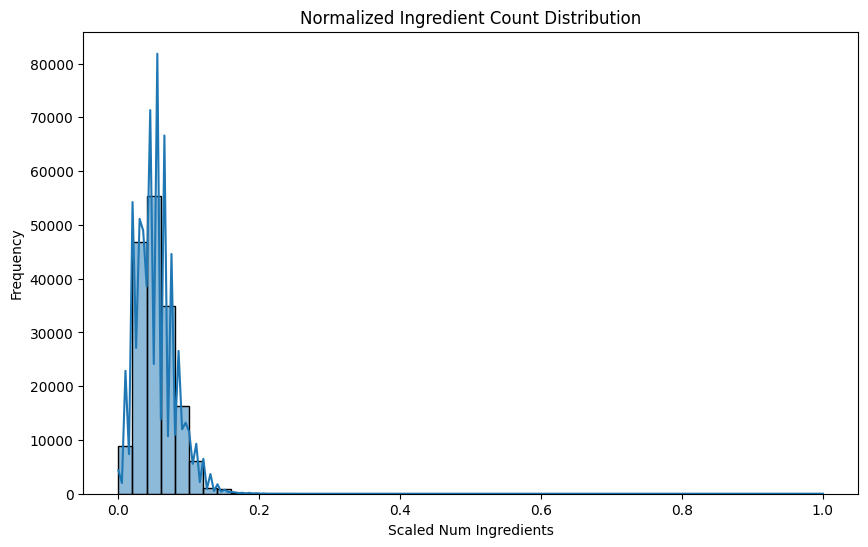

In [9]:
# Scaling to help training
scaler = MinMaxScaler()
df['num_ingredients_scaled'] = scaler.fit_transform(df[['num_ingredients']])

plt.figure(figsize=(10,6))
sns.histplot(df['num_ingredients_scaled'], bins=50, kde=True)
plt.title('Normalized Ingredient Count Distribution')
plt.xlabel('Scaled Num Ingredients')
plt.ylabel('Frequency')
plt.show()

In [10]:
# LOADING USDA FILES HERE
branded_food = pd.read_csv("branded_food.csv")  
food_nutrient = pd.read_csv("food_nutrient.csv")  
nutrient_info = pd.read_csv("nutrient.csv")  

branded_food = branded_food[['fdc_id', 'ingredients', 'serving_size', 'serving_size_unit', 'gtin_upc']]
food_nutrient = food_nutrient[['fdc_id', 'nutrient_id', 'amount']]
nutrient_info = nutrient_info[['id', 'name', 'unit_name']]

food_nutrient = food_nutrient.merge(nutrient_info, left_on='nutrient_id', right_on='id', how='left')
needed_nutrients = ["Energy", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]
food_nutrient = food_nutrient[food_nutrient['name'].isin(needed_nutrients)]

# Handle duplicate id values
food_nutrient = food_nutrient.groupby(['fdc_id', 'name'], as_index=False).agg({'amount': 'mean'})
food_nutrient_pivot = food_nutrient.pivot(index='fdc_id', columns='name', values='amount').reset_index()
food_nutrient_pivot.columns.name = None  # Remove hierarchical index name
food_nutrient_pivot = food_nutrient_pivot.rename_axis(None, axis=1)  # Fully reset column index

# Simplifying names easier syntaxing
food_nutrient_pivot = food_nutrient_pivot.rename(columns={
    "Energy": "calories",
    "Protein": "protein",
    "Total lipid (fat)": "fat",
    "Carbohydrate, by difference": "carbohydrates"
})
food_df = food_nutrient_pivot.merge(branded_food, on="fdc_id", how="left")

# Culling data set for testing purposes
# food_df = food_df.sample(n = int(len(df) * 0.0001), random_state = 42).reset_index(drop = True)

# Display sample of processed data
print(food_df.head())
print(food_df.shape)


C:\Users\david\AppData\Local\Temp\ipykernel_11508\1255449476.py:2: DtypeWarning: Columns (2,3,4,6,9,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv("branded_food.csv")


   fdc_id  carbohydrates  calories  protein    fat  \
0  344604           4.07      24.0     0.81   0.41   
1  344605           4.07      24.0     0.81   0.41   
2  344606           0.00       NaN    23.21   2.68   
3  344607           0.00       NaN    23.21   2.68   
4  344608           0.00       NaN    18.75  15.18   

                                         ingredients  serving_size  \
0  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
1  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
2                    White Turkey, Natural Flavoring         112.0   
3                   Turkey Breast, Natural Flavoring         112.0   
4                         Turkey, natural Flavoring.         112.0   

  serving_size_unit        gtin_upc  
0                 g  00072940755050  
1                 g  00072940755043  
2                 g  00642205534517  
3                 g  00642205510276  
4                 g  00642205534500  
(1874041, 9)


In [11]:
# NEEDED PREPROCESSING FOR FASTER PROCESSING WAY TOO SLOW
usda_ingredient_map = defaultdict(list)
for idx, row in food_df.iterrows():
    for ingredient in str(row['ingredients']).split(', '): 
        usda_ingredient_map[ingredient.lower()].append(row)

def match_ingredient_to_usda(ingredient_list):
    matched_nutrition = []
    # total = 0 #Used previously to track progress

    for ingredient in ingredient_list:
        # total += 1 # Progress tracker
        matches = usda_ingredient_map.get(ingredient.lower(), None)
        if matches:
            matched_nutrition.append(matches[0]) 
        else:
            # ERROR HANDLING
            matched_nutrition.append(None)
    return matched_nutrition

df['matched_nutrition'] = df['ingredients'].apply(match_ingredient_to_usda)
df['matched_nutrition'] = df['matched_nutrition'].apply( lambda x: [dict(item) if isinstance(item, pd.Series) else None for item in x] )

In [12]:
def compute_recipe_nutrition(matched_nutrition):
    if not matched_nutrition or all(item is None for item in matched_nutrition):  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})
    valid_nutrition = [item for item in matched_nutrition if item and isinstance(item, dict)]

    if not valid_nutrition:  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})

    valid_nutrition = [
        {k: item.get(k, 0) for k in ['calories', 'protein', 'fat', 'carbohydrates']}
        for item in valid_nutrition
    ]

    return pd.Series(pd.DataFrame(valid_nutrition).sum())

df[['calories', 'protein', 'fat', 'carbohydrates']] = df['matched_nutrition'].apply(compute_recipe_nutrition)

df = df.dropna()

print(df.head()) # Checking


                              title  \
0               No-Bake Nut Cookies   
1                       Creamy Corn   
2             Double Cherry Delight   
3  Eggless Milkless Applesauce Cake   
4                        Easy Fudge   

                                       measurements  \
0         [1 c, 1/2 c, 1/2 tsp, 1/2 c, 2 tbsp, 3 c]   
1    [2 oz, 1 oz, 1/3 c, 1/2 tsp, 1/2 tsp, 1/4 tsp]   
2            [1 oz, 1/2 c, 1 oz, 2 c, 1/8 tsp, 1 c]   
3  [3/4 c, 1/2 c, 1 c, 3 tsp, 1 tsp, 2 c, 1 c, 1 c]   
4                    [1 oz, 1 oz, 1 oz, 1 c, 1 tsp]   

                                         ingredients  num_ingredients  \
0  [firmly packed brown sugar, evaporated milk, v...                6   
1  [pkg frozen corn, pkg cream cheese cubed, butt...                6   
2  [can dark sweet pitted cherries, ginger ale, p...                6   
3  [sugar, shortening, applesauce, level  soda, e...                8   
4  [can sweetened condensed milk, pkg semisweet c...                5

In [13]:
bn_data = df[['num_ingredients', 'calories', 'protein', 'fat', 'carbohydrates']].copy()
bn_data.loc[:, 'calorie_category'] = pd.qcut(bn_data['calories'], q=3, labels=['Low', 'Medium', 'High'])
bn_data.loc[:, 'protein_category'] = pd.qcut(bn_data['protein'], q=3, labels=['Low', 'Medium', 'High'])
bn_data.loc[:, 'fat_category'] = pd.qcut(bn_data['fat'], q=3, labels=['Low', 'Medium', 'High'])
bn_data.loc[:, 'carb_category'] = pd.qcut(bn_data['carbohydrates'], q=3, labels=['Low', 'Medium', 'High'])

label_encoder = LabelEncoder()
for col in ['calorie_category', 'protein_category', 'fat_category', 'carb_category']:
    bn_data.loc[:, col] = bn_data[col].astype(str)
    bn_data.loc[:, col] = label_encoder.fit_transform(bn_data[col]).astype(int)

# Categorizing BASED ON INGREDIENT NUMBER (WE HAD TO SUB OUT FINANCIAL CONSTRAINT BECAUSE NO API EXISTED :C BUT IS OK ESTIMATE FOR NOW )
bn_data.loc[:, 'num_ingredients_cat'] = pd.qcut(bn_data['num_ingredients'], q=3, labels=['Few', 'Moderate', 'Many'])
bn_data.loc[:, 'num_ingredients_cat'] = bn_data['num_ingredients_cat'].astype(str)
bn_data.loc[:, 'num_ingredients_cat'] = label_encoder.fit_transform(bn_data['num_ingredients_cat']).astype(int)

print(bn_data.head())


C:\Users\david\AppData\Local\Temp\ipykernel_11508\3105581464.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 2 ... 1 1 1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  bn_data.loc[:, col] = label_encoder.fit_transform(bn_data[col]).astype(int)
C:\Users\david\AppData\Local\Temp\ipykernel_11508\3105581464.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 2 1 ... 1 2 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  bn_data.loc[:, col] = label_encoder.fit_transform(bn_data[col]).astype(int)
C:\Users\david\AppData\Local\Temp\ipykernel_11508\3105581464.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 2 1 ... 1 0 1]' has dtype incompatible with category, please expl

   num_ingredients  calories  protein    fat  carbohydrates  calorie_category  \
0                6       0.0    20.45  23.77          81.48                 1   
1                6       0.0    23.00  42.50         151.70                 1   
2                6     164.0     9.71   2.38          46.58                 2   
3                8    1344.0    37.94  88.96         321.51                 0   
4                5       0.0    14.10  20.60          54.50                 1   

   protein_category  fat_category  carb_category  num_ingredients_cat  
0                 2             1              1                    2  
1                 2             2              2                    2  
2                 1             1              1                    2  
3                 0             0              0                    1  
4                 1             1              1                    0  


C:\Users\david\AppData\Local\Temp\ipykernel_11508\3105581464.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 2 2 ... 1 2 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  bn_data.loc[:, 'num_ingredients_cat'] = label_encoder.fit_transform(bn_data['num_ingredients_cat']).astype(int)


In [14]:
bayesian_model = BayesianNetwork([
    ('num_ingredients_cat', 'calorie_category'),
    ('num_ingredients_cat', 'protein_category'),
    ('num_ingredients_cat', 'fat_category'),
    ('num_ingredients_cat', 'carb_category')
])

bayesian_model.fit(bn_data, estimator=MaximumLikelihoodEstimator)


In [15]:
inference = VariableElimination(bayesian_model)

# EX: Prob distribution for calorie_category | num_ingredients_cat = 0 (few)
query_result = inference.query(variables=["calorie_category"], evidence={"num_ingredients_cat": 0})
print("Probability distribution for calorie_category given num_ingredients_cat = 0 (Few ingredients):")
print(query_result)

query_result_multi = inference.query(variables=["protein_category", "fat_category"],
                                     evidence={"num_ingredients_cat": 2})
print("\nProbability distribution for protein_category and fat_category given num_ingredients_cat = 2 (Many ingredients):")
print(query_result_multi)


Probability distribution for calorie_category given num_ingredients_cat = 0 (Few ingredients):
+---------------------+-------------------------+
| calorie_category    |   phi(calorie_category) |
+=====================+=========================+
| calorie_category(0) |                  0.2103 |
+---------------------+-------------------------+
| calorie_category(1) |                  0.4295 |
+---------------------+-------------------------+
| calorie_category(2) |                  0.3602 |
+---------------------+-------------------------+

Probability distribution for protein_category and fat_category given num_ingredients_cat = 2 (Many ingredients):
+---------------------+-----------------+--------------------------------------+
| protein_category    | fat_category    |   phi(protein_category,fat_category) |
+=====================+=================+======================================+
| protein_category(0) | fat_category(0) |                               0.1491 |
+----------------